In [1]:
import numpy as np
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Advanced Statistical Methods Project

Dmitry Salnikov, 2018

### Data Generation



### Estimation goal

Following chapter 6 we consider estimation of linear functional i.e. 
$$\int_{0}^{1}f(x) dx$$

given set $\{ \psi_i \}_{i=1}^p$ of piecewise-constant basis functions $\psi_i = I[a_i, b_i)$ with non-overlapping supports i.e. $i \ne j \; [a_i, b_i)  \cap [a_j, b_j) = \emptyset$. The partition is **equidistant**

For $\gamma=(\gamma_1, \dots, \gamma_n) \sim N(0, 1)$ the true function is defined as:
$$
f(x, \theta) = \sum_{i=0}^{dim} {\gamma_i \psi_{i}(x)} \\
\gamma_i = \begin{cases}
\gamma_i, i \le 10 \\
\gamma_i/(i-10)^2, i > 10
\end{cases}
$$
In experiments we take $dim = 15$

Given n data points $\{ x_i \}_{i=1}^{n}$ the design matrix $\Psi$ is as usual defined as $p \times n$ matrix ${\psi_j(x_i)}$

Noise for homgenious and inhomogenious cases is generated as described in 7.6 of the [script](http://strlearn.ru/wp-content/uploads/2017/01/script2018.pdf)

### Weighting matrix


$$
\int_{0}^{1} c I[a, b) dx= c\int_{0}^{1} I[a, b)dx = c\int_{\max(0, a)}^{min(1, b)}dx = c(\min(1, b) - \max(0, a))
$$ 

Sice we consider c = 1 and function on the $[0, 1]$ interval, we can just say that $W_i = b_i - a_i$. Also, since our goal is estimation of integral W turns into the constant vector of size m(size of model canditate) $(\frac{1}{m}, \frac{1}{m}, \dots, \frac{1}{m})$

So, in case of integral estimation matrix $K_m = WS_m = W(\Psi \Psi^\top)^{-1} \Psi$

### Risk functional

 For the true value of parameter $\theta^*$ our target functional looks like $\int_{0}^{1} f(x, \theta^*)$
 For estimated coeffecient $\hat{\theta}$ we consider risk functional of the following form
$$R(\hat{\theta}) = \| W \hat{\theta} - \int_{0}^{1} f(x, \theta^*)\| + \sigma^2 tr(K_m K_m^\top)$$
where $W, K_m$ are defined as above
For oracle risk we consider true value estimated by Simpson's method using true function values

### Adaptive procedure

For the adaptive procedure we first split our data in half(even vs odd design points).
Then, first we estimate value of the integral on first half using Simpson's rule. Second is used to get an estimate of $\theta^*$. Then we compute the value of Risk functional between the estimated value of integral and $\hat{\theta}$. Then we do vise versa and average value of risk.

In all plots we plot target function instead of the integral, since drawing constant is not that interesting.

In [2]:
def piecewise_const_function(c, x, y):
    assert(x <= y)
    def function(point):
        if point >= x and point < y:
            return c
        else:
            return 0
    return np.vectorize(function)

In [3]:
N_POINTS = 300
x = np.linspace(0, 1, num=N_POINTS)

In [4]:
def true_function_1(n):
    gamma = np.random.standard_normal(size=n)
    gamma[11:] /= (np.arange(11, n) - 10)**2
    
    def function(x):
        basis_function_values = np.zeros_like(gamma)
        basis_function_values[np.arange(0, n, 2)] = np.cos(2 * np.pi * x * np.arange(0, n, 2)) / np.sqrt(2)
        basis_function_values[np.arange(1, n, 2)] = np.sin(2 * np.pi * x* np.arange(1, n, 2)) / np.sqrt(2)
        return np.sum(basis_function_values * gamma)
     
    return np.vectorize(function), gamma

In [5]:
def generate_noise(x, sigma=1.0, homogenious=True):
    dimensions = x.shape[0]
    noise_intensity = 0.8
    if homogenious:
        return np.random.normal(scale=sigma, size=dimensions)
    else:
        sigma_initial = np.random.multivariate_normal(2 * np.ones(dimensions), noise_intensity * np.eye(dimensions))
        return np.random.multivariate_normal(np.zeros(dimensions), np.diag(sorted(noise_intensity*sigma_initial**2)))

In [6]:
def generate_basis(start, end, m, value=1):
    basis_functions = []
    interval_size = (end - start) / m
    for ith_interval in range(m):
        func = piecewise_const_function(value, ith_interval * interval_size, (ith_interval + 1) * interval_size)
        basis_functions.append(func)
    return basis_functions

def generate_w(start, end, m):
    w = []
    interval_size = (end - start) / m
    for i in range(m):
        w.append(interval_size)
    return np.array(w)

def generate_psi(x, m):
    PSI_arr = []
    for basis_function in generate_basis(0, 1, m):
        PSI_arr.append(basis_function(x).astype(np.float64))
    PSI = np.vstack(PSI_arr)
    return PSI

def fit(x, y, m):
    PSI = generate_psi(x, m=m)
    S = (np.linalg.pinv(PSI @ PSI.T) @ PSI)
    theta = S @ y
    prediction = PSI.T @ theta
    return prediction, theta, S

def calculate_risk(true_value, theta_prediction, S, W, sigma):
    diff = true_value - (W @ theta_prediction)
    K = W @ S
    return np.linalg.norm(diff)**2 + sigma**2  * (K@K.T)

def holdout_estimate(x, y, m):
    W = generate_w(0, 1, m)
    dim = x.shape[0]
    x_1 = x[0:dim:2]
    y_1 = y[0:dim:2]
    x_2 = x[1:dim:2]
    y_2 = y[1:dim:2]

    prediction_1, theta_1, S_1 = fit(x_1, y_1, m)
    true_value_1 = scipy.integrate.simps(y_2, x_2)
    risk1 = calculate_risk(true_value_1, theta_1, S_1, W, sigma)
    
    prediction_2, theta_2, S_2 = fit(x_2, y_2, m)
    true_value_2 = scipy.integrate.simps(y_1, x_1)
    risk2 = calculate_risk(true_value_2, theta_2, S_2, W, sigma)

    return (risk1 + risk2) / 2

def calculate_oracle_choice(x, y): 
    oracle_errors = []
    true_value = scipy.integrate.simps(true_function(x), x)
    for i in tqdm_notebook(range(1, 300)):
        pred_temp, theta_temp, S_temp = fit(x, y, i)
        W_temp = generate_w(0, 1, i)
        oracle_errors.append(calculate_risk(true_value, theta_temp, S_temp, W_temp, sigma))

    oracle_choice = np.argmin(oracle_errors)
    return oracle_choice, oracle_errors

def calculate_adaptive_choice(x, y):
    holdout_errors = []
    true_value = scipy.integrate.simps(true_function(x), x)
    for i in tqdm_notebook(range(1, 300)):
        holdout_errors.append(holdout_estimate(x, y, i))
    adaptive_choice = np.argmin(holdout_errors)
    return adaptive_choice, holdout_errors

def plot_all(x, y, oc, ac, ax=None):
    prediction_1, theta_1, S_1 = fit(x, y, oc)
    prediction_2, theta_2, S_2 = fit(x, y, ac)
    W = generate_w(0, 1, dim)
    
    with sns.axes_style('darkgrid'):
        if ax is None:
            ax = plt.figure(figsize=(10, 5)).gca()
        ax.plot(x, prediction_1, label='oracle choice prediction', color='black')
        ax.plot(x, prediction_2, label='adaptive prediction', color='blue')
        ax.plot(x, true_function(x), label='true function', color='red')
        ax.scatter(x, y, label='observed', alpha=0.4, color='grey')
        ax.legend(loc='best')
    #     true_value = scipy.integrate.simps(true_function(x), x)
    #     plt.title('Plot of estimated function. Oracle risk for the integral: {}'.format(calculate_risk(true_value, theta, W)))
        plt.show()

In [7]:
true_function, true_theta = true_function_1(15)

## Homogenious noise

In [8]:
sigma=0.8
noise = generate_noise(x, sigma)
y = true_function(x) + noise

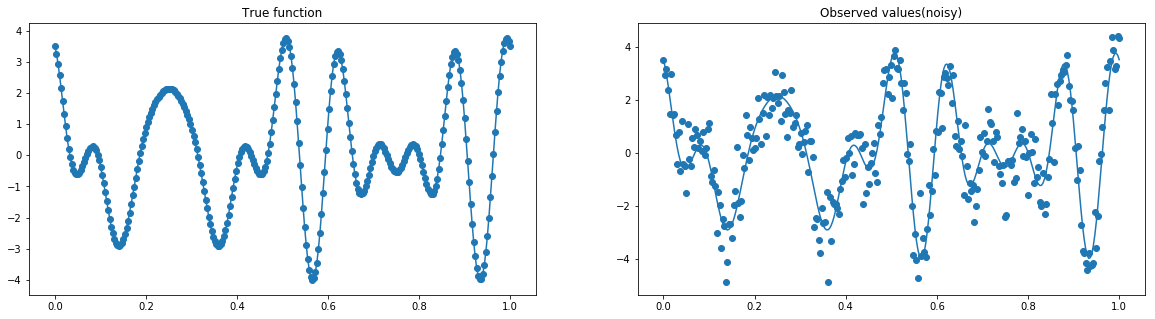

In [9]:
### with sns.axes_style('darkgrid'):
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax1.plot(x, true_function(x))
ax1.set_title('True function')
ax1.scatter(x, true_function(x))
ax2.scatter(x, true_function(x) + noise)
ax2.plot(x, true_function(x))
ax2.set_title('Observed values(noisy)')
plt.show()

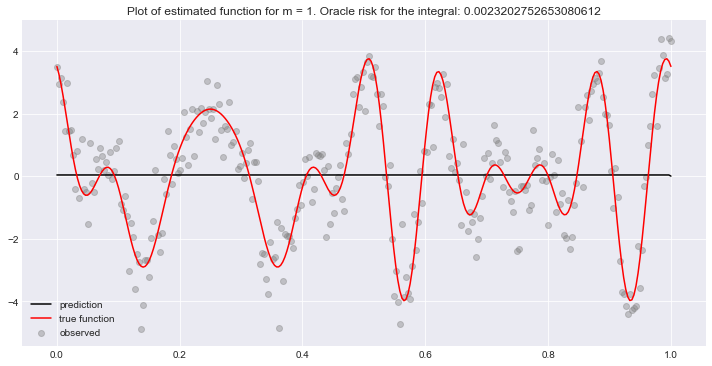

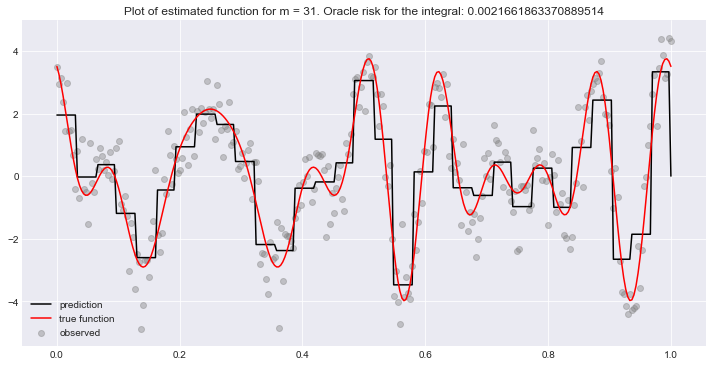

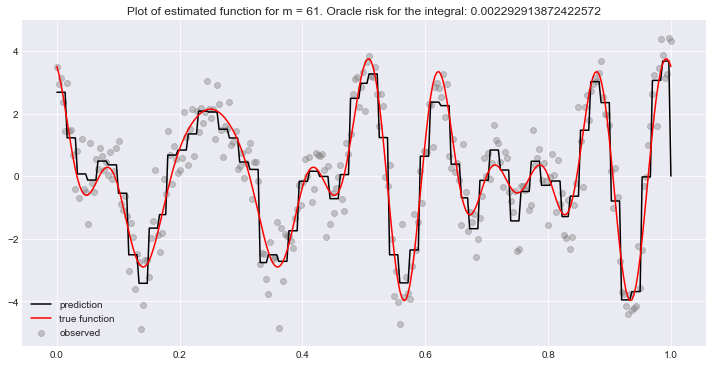

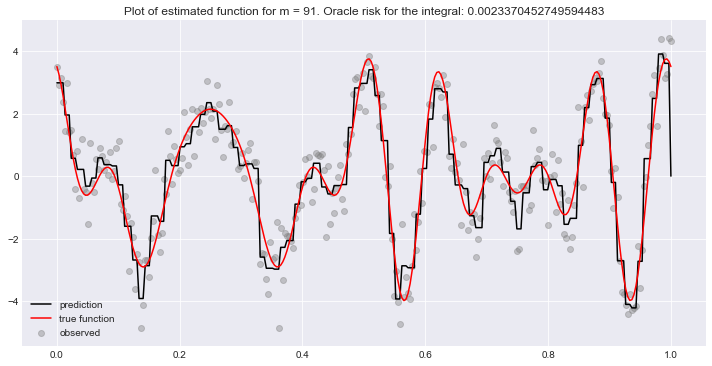

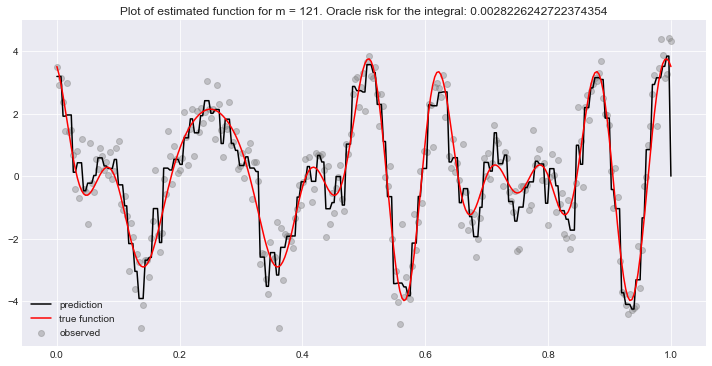

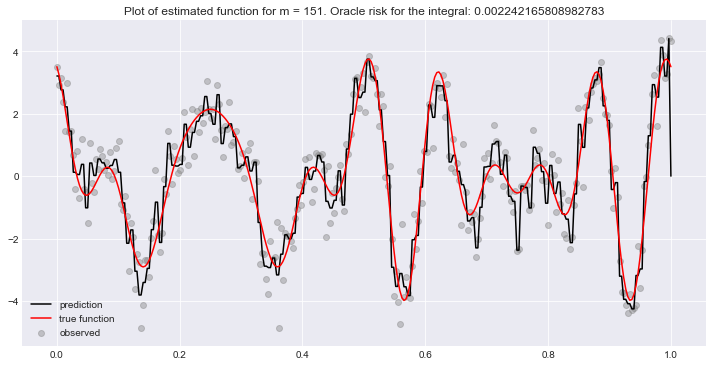

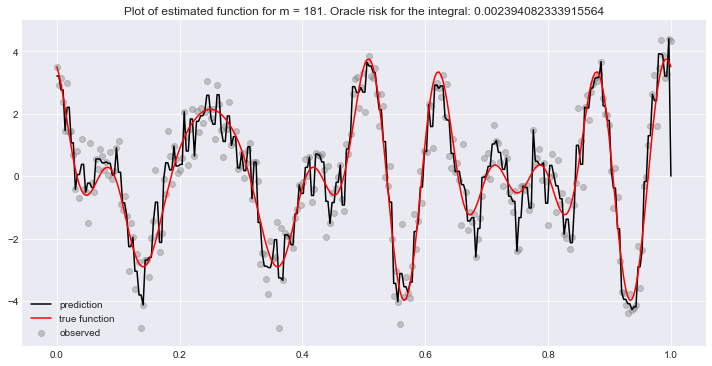

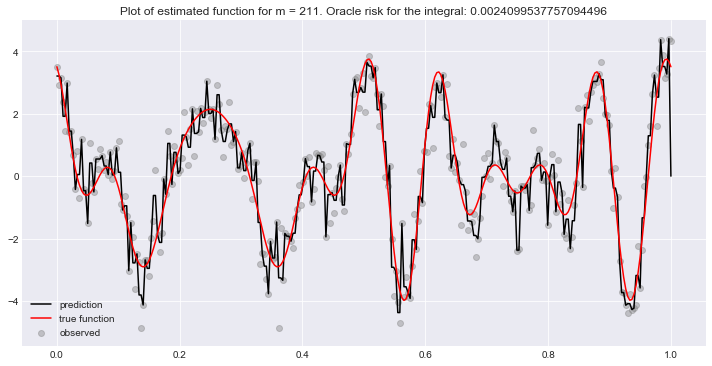

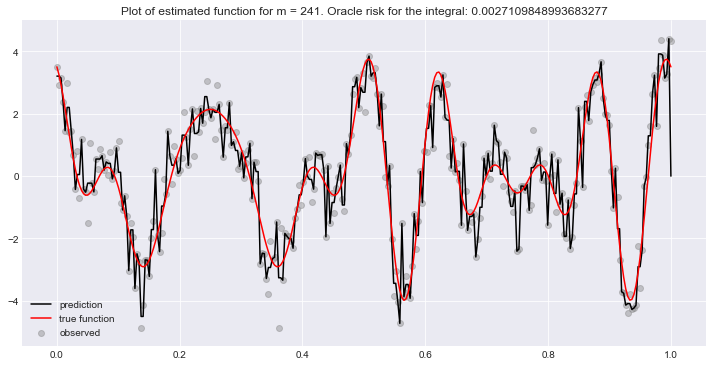

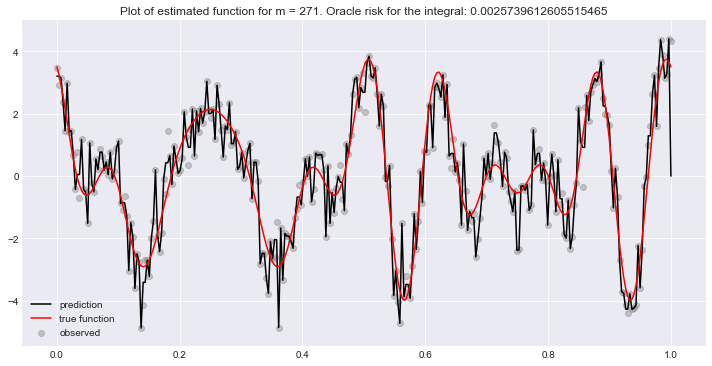

In [10]:
for i in range(1, 300, 30):
    dim = i
    prediction, theta, S= fit(x, y, dim)
    W = generate_w(0, 1, dim)
    
    with sns.axes_style('darkgrid'):
        plt.figure(figsize=(10, 5))
        plt.plot(x, prediction, label='prediction', color='black')
        plt.plot(x, true_function(x), label='true function', color='red')
        plt.scatter(x, y, label='observed', alpha=0.4, color='grey')
        plt.legend(loc='best')
        plt.tight_layout()
        true_value = scipy.integrate.simps(true_function(x), x)
        plt.title('Plot of estimated function for m = {}. Oracle risk for the integral: {}'.format(dim, calculate_risk(true_value, theta, S, W, sigma)))
        plt.show()

HBox(children=(IntProgress(value=0, max=299), HTML(value='')))

HBox(children=(IntProgress(value=0, max=299), HTML(value='')))


Oracle choice 50
Risk with oracle choice: 0.002142528102602744
Adaptive choice 138
Risk with adaptive choice: 0.011964918719511893


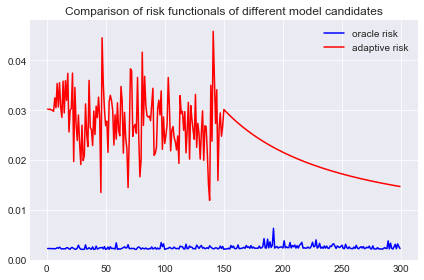

In [11]:
oracle_choice, oracle_errors = calculate_oracle_choice(x, y)
adaptive_choice, holdout_errors = calculate_adaptive_choice(x, y)

    
print('Oracle choice {}'.format(oracle_choice + 1))
print('Risk with oracle choice: {}'.format(np.min(oracle_errors)))
print('Adaptive choice {}'.format(adaptive_choice + 1))
print('Risk with adaptive choice: {}'.format(np.min(holdout_errors)))

with sns.axes_style('darkgrid'):
    plt.plot(np.arange(1, 300), oracle_errors, color='blue', label='oracle risk')
    plt.plot(np.arange(1, 300), holdout_errors, color='red', label='adaptive risk')
    plt.title('Comparison of risk functionals of different model candidates'.format(oracle_choice))
    plt.legend()
    plt.tight_layout()
    plt.show()

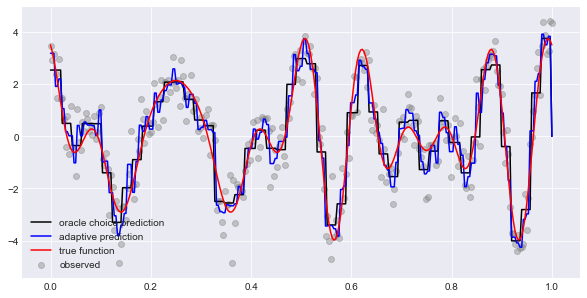

In [12]:
plot_all(x, y, oracle_choice, adaptive_choice)

## Inhomogenious noize

In [13]:
noise_ih = generate_noise(x, sigma, homogenious=False)
y_ih = true_function(x) + noise_ih

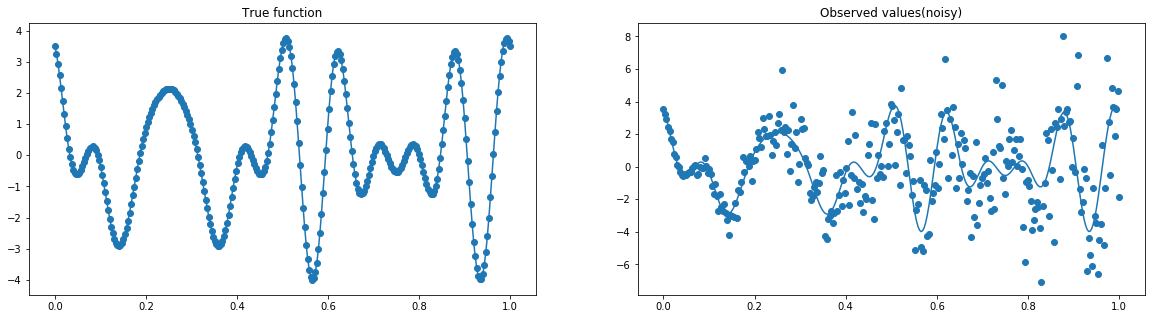

In [14]:
### with sns.axes_style('darkgrid'):
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax1.plot(x, true_function(x))
ax1.set_title('True function')
ax1.scatter(x, true_function(x))
ax2.scatter(x, y_ih)
ax2.plot(x, true_function(x))
ax2.set_title('Observed values(noisy)')
plt.show()

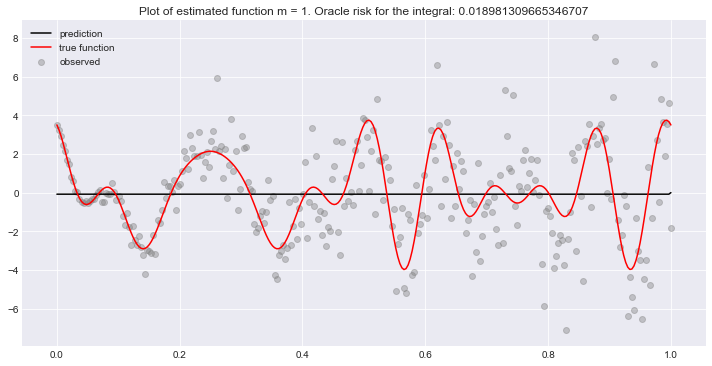

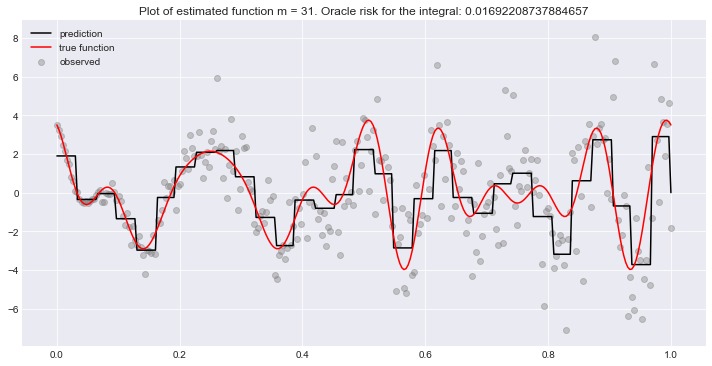

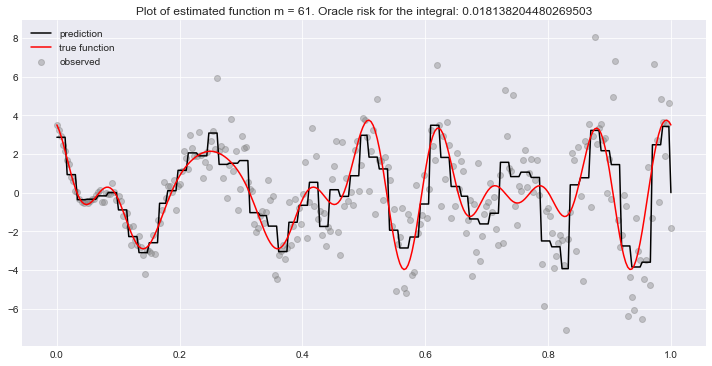

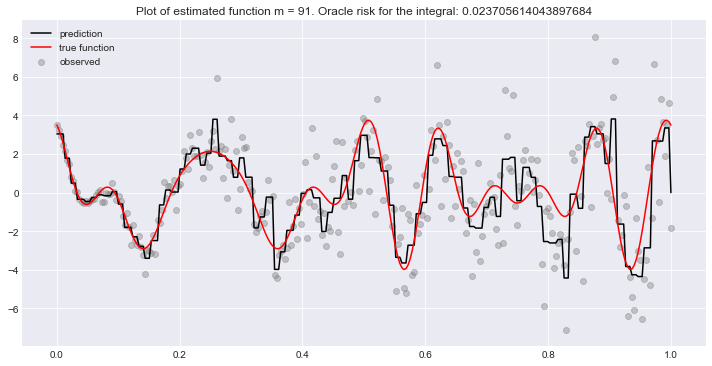

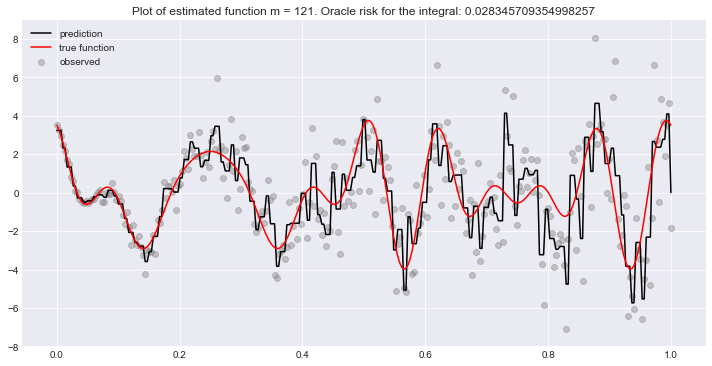

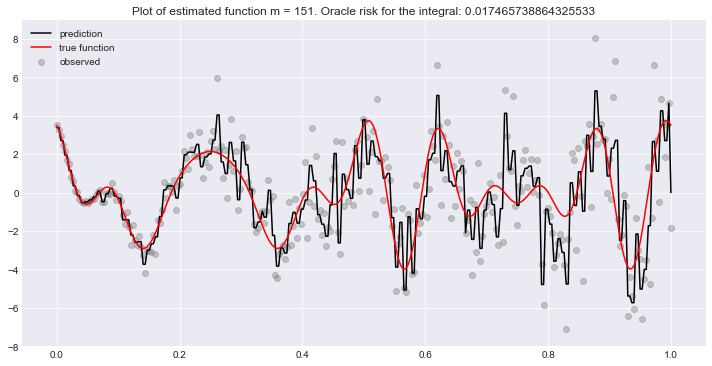

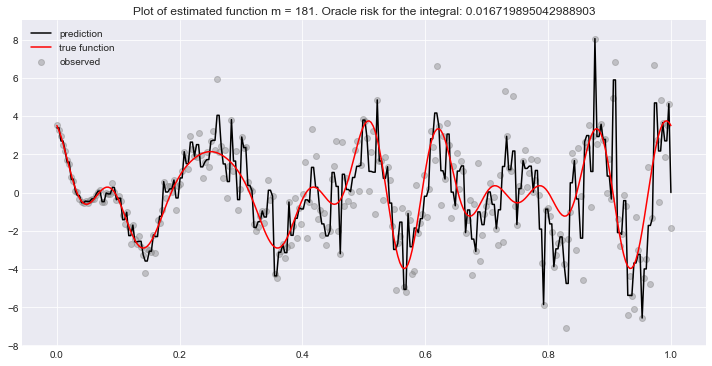

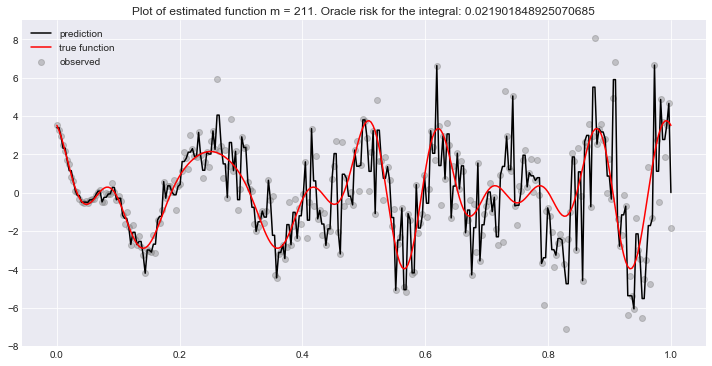

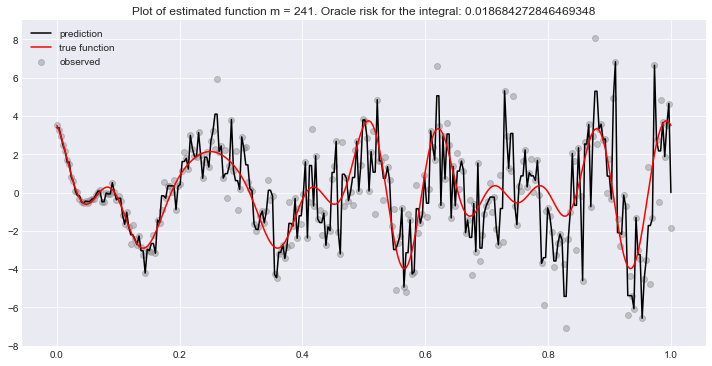

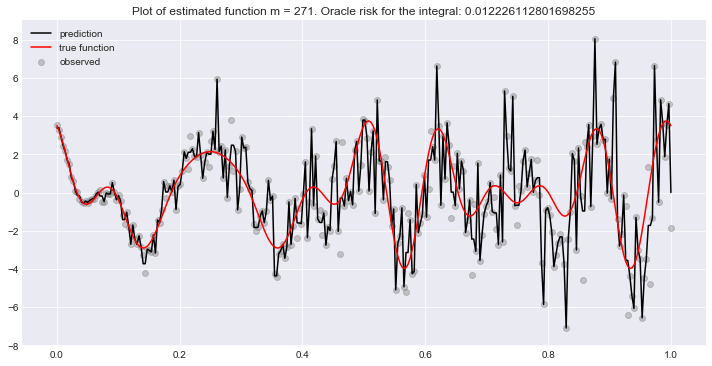

In [15]:
for i in range(1, 300, 30):
    dim = i
    prediction, theta, S = fit(x, y_ih, dim)
    W = generate_w(0, 1, dim)

    with sns.axes_style('darkgrid'):
        plt.figure(figsize=(10, 5))
        plt.plot(x, prediction, label='prediction', color='black')
        plt.plot(x, true_function(x), label='true function', color='red')
        plt.scatter(x, y_ih, label='observed', alpha=0.4, color='grey')
        plt.legend(loc='best')
        plt.tight_layout()
        true_value = scipy.integrate.simps(true_function(x), x)
        plt.title('Plot of estimated function m = {}. Oracle risk for the integral: {}'.format(dim, calculate_risk(true_value, theta, S, W, sigma)))
        plt.show()

HBox(children=(IntProgress(value=0, max=299), HTML(value='')))

HBox(children=(IntProgress(value=0, max=299), HTML(value='')))


Oracle choice 216
Risk with oracle choice: 0.004281855120536228
Adaptive choice 133
Risk with adaptive choice: 0.005169262874810776


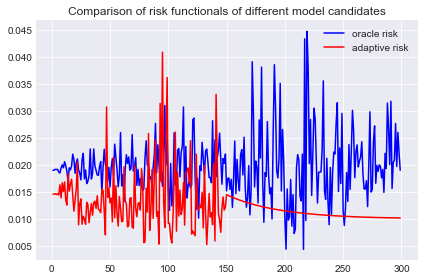

In [16]:
oracle_choice, oracle_errors = calculate_oracle_choice(x, y_ih)
adaptive_choice, holdout_errors = calculate_adaptive_choice(x, y_ih)

    
print('Oracle choice {}'.format(oracle_choice + 1))
print('Risk with oracle choice: {}'.format(np.min(oracle_errors)))
print('Adaptive choice {}'.format(adaptive_choice + 1))
print('Risk with adaptive choice: {}'.format(np.min(holdout_errors)))

with sns.axes_style('darkgrid'):
    plt.plot(np.arange(1, 300), oracle_errors, color='blue', label='oracle risk')
    plt.plot(np.arange(1, 300), holdout_errors, color='red', label='adaptive risk')
    plt.title('Comparison of risk functionals of different model candidates'.format(oracle_choice))
    plt.legend()
    plt.tight_layout()
    plt.show()

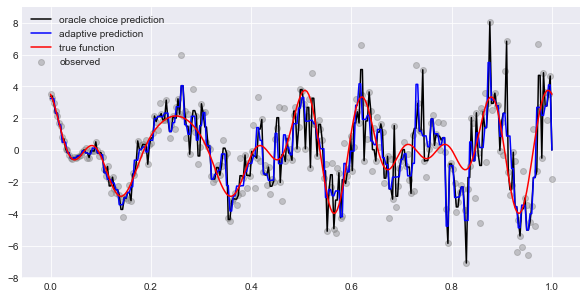

In [17]:
plot_all(x, y_ih, oracle_choice, adaptive_choice)